# SpringBoard Capstone2: Coronavirus Tweets

    Data from Kaggle.com: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification/metadata
## Data Explore and Preprocessing

In [1]:
# !pip install wordcloud

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Ling/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud
import re
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
tweet_whole_train = pd.read_csv('/Users/Ling/Desktop/01_Springboard/Corona_Tweet/Data/Corona_NLP_train.csv', index_col = 0)
print(tweet_whole_train.info())
test = pd.read_csv('/Users/Ling/Desktop/01_Springboard/Corona_Tweet/Data/Corona_NLP_test.csv', index_col = 0)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 3799 to 44955
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ScreenName     41157 non-null  int64 
 1   Location       32567 non-null  object
 2   TweetAt        41157 non-null  object
 3   OriginalTweet  41157 non-null  object
 4   Sentiment      41157 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 1 to 3798
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ScreenName     3798 non-null   int64 
 1   Location       2964 non-null   object
 2   TweetAt        3798 non-null   object
 3   OriginalTweet  3798 non-null   object
 4   Sentiment      3798 non-null   object
dtypes: int64(1), object(4)
memory usage: 178.0+ KB
None


In [5]:
print(tweet_whole_train.head())

          ScreenName   Location     TweetAt  \
UserName                                      
3799           48751     London  16-03-2020   
3800           48752         UK  16-03-2020   
3801           48753  Vagabonds  16-03-2020   
3802           48754        NaN  16-03-2020   
3803           48755        NaN  16-03-2020   

                                              OriginalTweet  \
UserName                                                      
3799      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
3800      advice Talk to your neighbours family to excha...   
3801      Coronavirus Australia: Woolworths to give elde...   
3802      My food stock is not the only one which is emp...   
3803      Me, ready to go at supermarket during the #COV...   

                   Sentiment  
UserName                      
3799                 Neutral  
3800                Positive  
3801                Positive  
3802                Positive  
3803      Extremely Negative  


In [6]:
tweet = tweet_whole_train[['OriginalTweet', 'Sentiment']]

In [7]:
np.sum(tweet.isnull().any(axis=1))

0

In [8]:
np.unique(tweet.Sentiment, return_counts = True)

(array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
        'Positive'], dtype=object),
 array([ 5481,  6624,  9917,  7713, 11422]))

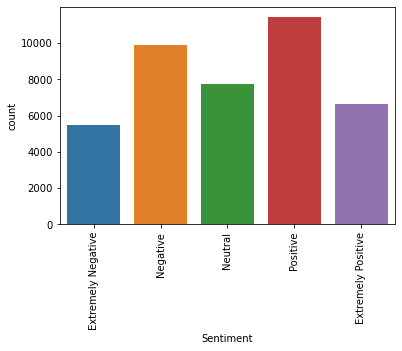

In [9]:
order = ['Extremely Negative', 'Negative', 'Neutral','Positive','Extremely Positive']
sns.countplot(x = 'Sentiment', data = tweet, order = order)
plt.xticks(rotation = 90)
plt.show()

#### reference: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

In [10]:
# lower case all text
tweet['OriginalTweet'] = tweet['OriginalTweet'].str.lower()
#tweet['OriginalTweet'] = tweet_text 
tweet['OriginalTweet'].head(10)

<ipython-input-10-a4d75c87a5e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].str.lower()


UserName
3799    @menyrbie @phil_gahan @chrisitv https://t.co/i...
3800    advice talk to your neighbours family to excha...
3801    coronavirus australia: woolworths to give elde...
3802    my food stock is not the only one which is emp...
3803    me, ready to go at supermarket during the #cov...
3804    as news of the regions first confirmed covid-...
3805    cashier at grocery store was sharing his insig...
3806    was at the supermarket today. didn't buy toile...
3807    due to covid-19 our retail store and classroom...
3808    for corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [11]:
stopwordlist = ['a','ain', 'am', 'an',
             'and','any','are', 'as', 'at', 'be',  'before',
             'being', 'between', 'by', 'can', 'd', 'do',
             'does', 'doing',  'during',  'for', 'from',
             'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'in',
             'into','is', 'it', 'its', 'itself', 'll', 'm', 'ma',
             'me', 'my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'or',  'our', 'ours','ourselves',  'own', 're','s', 'she', "shes", 
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 've', 
             'we',  'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))
tweet['OriginalTweet'].head()

<ipython-input-12-6c09ff49c4a4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: cleaning_stopwords(text))


UserName
3799    @menyrbie @phil_gahan @chrisitv https://t.co/i...
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia: woolworths give elderly...
3802    food stock not only one empty... please, don't...
3803    me, ready go supermarket #covid19 outbreak. no...
Name: OriginalTweet, dtype: object

In [13]:
def remove_at_signs(text):
    return " ".join([word for word in str(text).split() if not word.startswith('@')])
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: remove_at_signs(text))
tweet['OriginalTweet'].head()

<ipython-input-13-2bef1d3d1219>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda text: remove_at_signs(text))


UserName
3799    https://t.co/ifz9fan2pa https://t.co/xx6ghgfzc...
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia: woolworths give elderly...
3802    food stock not only one empty... please, don't...
3803    me, ready go supermarket #covid19 outbreak. no...
Name: OriginalTweet, dtype: object

In [14]:
def cleaning_URLs(data):
    return re.sub('[^ ]+\.[^ ]+' , ' url', data)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_URLs(x))
tweet['OriginalTweet'].head()

<ipython-input-14-dbc6b0c6c066>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_URLs(x))


UserName
3799                                        url  url  url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia: woolworths give elderly...
3802    food stock not only one  url please, don't pan...
3803    me, ready go supermarket #covid19 outbreak. no...
Name: OriginalTweet, dtype: object

In [15]:
tweet.loc[3799, 'OriginalTweet']

' url  url  url'

In [16]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans(' ', ' ', punctuations_list)
    return text.translate(translator)
tweet['OriginalTweet']= tweet['OriginalTweet'].apply(lambda x: cleaning_punctuations(x))
tweet['OriginalTweet'].head()

<ipython-input-16-c0b58da7c31c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet']= tweet['OriginalTweet'].apply(lambda x: cleaning_punctuations(x))


UserName
3799                                        url  url  url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia woolworths give elderly ...
3802    food stock not only one  url please dont panic...
3803    me ready go supermarket covid19 outbreak not b...
Name: OriginalTweet, dtype: object

In [17]:
import itertools
def cleaning_repeating_char(text):
    cl = ''.join(ch for ch, _ in itertools.groupby(text))
    return cl
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))
tweet['OriginalTweet'].head(10)

<ipython-input-17-260ba1a553fd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_repeating_char(x))


UserName
3799                                          url url url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia wolworths give elderly d...
3802    fod stock not only one url please dont panic e...
3803    me ready go supermarket covid19 outbreak not b...
3804    news regions first confirmed covid19 case cam...
3805    cashier grocery store was sharing insights cov...
3806    was supermarket today didnt buy toilet paper r...
3807    due covid19 retail store clasrom atlanta not o...
3808    corona preventionwe should stop buy things cas...
Name: OriginalTweet, dtype: object

In [18]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_numbers(x))
tweet['OriginalTweet'].head(10)

<ipython-input-18-39d2e1561b65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: cleaning_numbers(x))


UserName
3799                                          url url url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia wolworths give elderly d...
3802    fod stock not only one url please dont panic e...
3803    me ready go supermarket covid outbreak not bec...
3804    news regions first confirmed covid case came ...
3805    cashier grocery store was sharing insights cov...
3806    was supermarket today didnt buy toilet paper r...
3807    due covid retail store clasrom atlanta not ope...
3808    corona preventionwe should stop buy things cas...
Name: OriginalTweet, dtype: object

In [19]:
# # Remove non_English words
# import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())
# def remove_non_english(text):
#     eng = " ".join(w for w in nltk.wordpunct_tokenize(text) \
#          if w.lower() in words or not w.isalpha())
#     return eng

# tweet['OriginalTweet'] = tweet['OriginalTweet'].apply(lambda x: remove_non_english(x))
# tweet['OriginalTweet'].head(10)

In [20]:
# # Get the first original tweet to learn how tweet tokenizer works
# Try_tweet1 = tweet.iloc[0, 3]
# print(Try_tweet1)
# print(tweet.iloc[0, 4])
# Try_token = nltk.tokenize.TweetTokenizer().tokenize(Try_tweet1)
# print(Try_token)

In [21]:
# Tokenize the OriginalTweet text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tweet['Tokens'] = [tknzr.tokenize(t) for t in tweet['OriginalTweet']]
tweet['Tokens'].head()

<ipython-input-21-116119311db9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens'] = [tknzr.tokenize(t) for t in tweet['OriginalTweet']]


UserName
3799                                      [url, url, url]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, wolworths, give, elde...
3802    [fod, stock, not, only, one, url, please, dont...
3803    [me, ready, go, supermarket, covid, outbreak, ...
Name: Tokens, dtype: object

In [22]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
tweet['Tokens']= tweet['Tokens'].apply(lambda x: stemming_on_text(x))
tweet['Tokens'].head(10)

<ipython-input-22-9e413b8e77ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens']= tweet['Tokens'].apply(lambda x: stemming_on_text(x))


UserName
3799                                      [url, url, url]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, wolworths, give, elde...
3802    [fod, stock, not, only, one, url, please, dont...
3803    [me, ready, go, supermarket, covid, outbreak, ...
3804    [news, region, , s, first, confirmed, covid, ...
3805    [cashier, grocery, store, was, sharing, insigh...
3806    [was, supermarket, today, didnt, buy, toilet, ...
3807    [due, covid, retail, store, clasrom, atlanta, ...
3808    [corona, preventionwe, should, stop, buy, thin...
Name: Tokens, dtype: object

In [23]:
lm = nltk.stem.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
tweet['Tokens'] = tweet['Tokens'].apply(lambda x: lemmatizer_on_text(x))
tweet['Tokens'].head(10)

<ipython-input-23-da252269bd34>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['Tokens'] = tweet['Tokens'].apply(lambda x: lemmatizer_on_text(x))


UserName
3799                                      [url, url, url]
3800    [advice, talk, neighbours, family, exchange, p...
3801    [coronavirus, australia, wolworths, give, elde...
3802    [fod, stock, not, only, one, url, please, dont...
3803    [me, ready, go, supermarket, covid, outbreak, ...
3804    [news, region, , s, first, confirmed, covid, ...
3805    [cashier, grocery, store, was, sharing, insigh...
3806    [was, supermarket, today, didnt, buy, toilet, ...
3807    [due, covid, retail, store, clasrom, atlanta, ...
3808    [corona, preventionwe, should, stop, buy, thin...
Name: Tokens, dtype: object

In [24]:
tweet['text'] = tweet["Tokens"].map(' '.join)
print(tweet['text'].head(10))

UserName
3799                                          url url url
3800    advice talk neighbours family exchange phone n...
3801    coronavirus australia wolworths give elderly d...
3802    fod stock not only one url please dont panic e...
3803    me ready go supermarket covid outbreak not bec...
3804    news region  s first confirmed covid case cam...
3805    cashier grocery store was sharing insights cov...
3806    was supermarket today didnt buy toilet paper r...
3807    due covid retail store clasrom atlanta not ope...
3808    corona preventionwe should stop buy things cas...
Name: text, dtype: object


<ipython-input-24-cc0ea48d3dc6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet['text'] = tweet["Tokens"].map(' '.join)


In [25]:
# from sklearn.feature_extraction.text import CountVectorizer  
# from sklearn.model_selection import train_test_split 

# X = tweet['text'] 

# y = tweet['Sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Count_vect = CountVectorizer()
# Count_train = Count_vect.fit_transform(X_train)

# Count_test = Count_vect.transform(X_test)

# print(Count_vect.get_feature_names()[:10])

In [26]:
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.model_selection import train_test_split 

# X = tweet['Tokens']
# y = tweet['Sentiment']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# # Vectorize the X
# MLB_vect = MultiLabelBinarizer()

# MLB_X_train = MLB_vect.fit_transform(X_train)

# MLB_X_test = MLB_vect.transform(X_test)

# len(MLB_vect.classes_)

In [38]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 

X = tweet['text'] 

y = tweet['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 10, max_df = 0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print('# of feature names', len(tfidf_vectorizer.get_feature_names()))
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[1])

# of feature names 5535
['abc', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'absurd', 'abt', 'abuse']
[0. 0. 0. ... 0. 0. 0.]


In [39]:
## get running time
%time

## Try NaiveBayes first
# Import the necessary modules
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier

# # using tfidf ## F1 0.44 fast to run
# NB_classifier = MultinomialNB()
# # Fit the classifier to the training data
# NB_classifier.fit(tfidf_train, y_train)
# # Create the predicted tags: pred
# pred = NB_classifier.predict(tfidf_test)
# # Calculate the accuracy score: score
# Score = metrics.accuracy_score(y_test, pred)
# print(Score)
# # Calculate the confusion matrix: cm
# CM = metrics.confusion_matrix(y_test, pred)
# print(CM)


# # Using Count_train
# nb_classifier = MultinomialNB()
# # Fit the classifier to the training data
# nb_classifier.fit(Count_train, y_train)
# # Create the predicted tags: pred
# pred = nb_classifier.predict(Count_test)
# # Calculate the accuracy score: score
# score = metrics.accuracy_score(y_test, pred)
# print(Score)
# # Calculate the confusion matrix: cm
# cm = metrics.confusion_matrix(y_test, pred)
# print(CM)

# # F1 = 0.49 fast to run
# BNBmodel = BernoulliNB()
# BNBmodel.fit(tfidf_train, y_train)
# y_pred = BNBmodel.predict(tfidf_test)
# print(classification_report(y_test, y_pred))
# print(metrics.accuracy_score(y_test, y_pred))

## F1 LinearSVC = 0.56
SVCmodel = LinearSVC()
SVCmodel.fit(tfidf_train, y_train)
y_pred = SVCmodel.predict(tfidf_test)
print(classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
CM = metrics.confusion_matrix(y_test, y_pred)
print(CM)





CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11.9 µs
                    precision    recall  f1-score   support

Extremely Negative       0.60      0.61      0.61      1342
Extremely Positive       0.65      0.63      0.64      1674
          Negative       0.50      0.47      0.48      2466
           Neutral       0.60      0.70      0.65      1939
          Positive       0.52      0.50      0.51      2869

          accuracy                           0.56     10290
         macro avg       0.57      0.58      0.58     10290
      weighted avg       0.56      0.56      0.56     10290

0.5648202137998056
[[ 823    9  391   52   67]
 [   9 1047   64   62  492]
 [ 422   69 1155  361  459]
 [  28   28  227 1349  307]
 [  85  465  469  412 1438]]


In [29]:
## get running time
%time

# hyper prameter tuning for SVC:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 100], 'gamma': [1,0.001], 'kernel':['rbf','poly','sigmoid','linear'], 'degree':[0, 3]}
grid = GridSearchCV(SVC(),param_grid,scoring='accuracy', verbose=10)
grid.fit(tfidf_train,y_train)
 

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START C=0.1, degree=0, gamma=1, kernel=rbf.......................
[CV 1/5; 1/32] END .....C=0.1, degree=0, gamma=1, kernel=rbf; total time= 4.5min
[CV 2/5; 1/32] START C=0.1, degree=0, gamma=1, kernel=rbf.......................
[CV 2/5; 1/32] END .....C=0.1, degree=0, gamma=1, kernel=rbf; total time= 4.6min
[CV 3/5; 1/32] START C=0.1, degree=0, gamma=1, kernel=rbf.......................
[CV 3/5; 1/32] END .....C=0.1, degree=0, gamma=1, kernel=rbf; total time= 4.6min
[CV 4/5; 1/32] START C=0.1, degree=0, gamma=1, kernel=rbf.......................
[CV 4/5; 1/32] END .....C=0.1, degree=0, gamma=1, kernel=rbf; total time= 4.8min
[CV 5/5; 1/32] START C=0.1, degree=0, gamma=1, kernel=rbf.......................
[CV 5/5; 1/32] END .....C=0.1, degree=0, gamma=1, kernel=rbf; total time= 4.7min
[CV 1/5; 2/32] START C=0.1, degree=0, gamma=1, kernel=poly......

[CV 1/5; 11/32] END C=0.1, degree=3, gamma=1, kernel=sigmoid; total time= 3.9min
[CV 2/5; 11/32] START C=0.1, degree=3, gamma=1, kernel=sigmoid..................
[CV 2/5; 11/32] END C=0.1, degree=3, gamma=1, kernel=sigmoid; total time= 3.9min
[CV 3/5; 11/32] START C=0.1, degree=3, gamma=1, kernel=sigmoid..................
[CV 3/5; 11/32] END C=0.1, degree=3, gamma=1, kernel=sigmoid; total time= 3.8min
[CV 4/5; 11/32] START C=0.1, degree=3, gamma=1, kernel=sigmoid..................
[CV 4/5; 11/32] END C=0.1, degree=3, gamma=1, kernel=sigmoid; total time= 3.8min
[CV 5/5; 11/32] START C=0.1, degree=3, gamma=1, kernel=sigmoid..................
[CV 5/5; 11/32] END C=0.1, degree=3, gamma=1, kernel=sigmoid; total time= 3.8min
[CV 1/5; 12/32] START C=0.1, degree=3, gamma=1, kernel=linear...................
[CV 1/5; 12/32] END .C=0.1, degree=3, gamma=1, kernel=linear; total time= 4.1min
[CV 2/5; 12/32] START C=0.1, degree=3, gamma=1, kernel=linear...................
[CV 2/5; 12/32] END .C=0.1, 

[CV 2/5; 21/32] END C=100, degree=0, gamma=0.001, kernel=rbf; total time= 4.1min
[CV 3/5; 21/32] START C=100, degree=0, gamma=0.001, kernel=rbf..................
[CV 3/5; 21/32] END C=100, degree=0, gamma=0.001, kernel=rbf; total time= 4.0min
[CV 4/5; 21/32] START C=100, degree=0, gamma=0.001, kernel=rbf..................
[CV 4/5; 21/32] END C=100, degree=0, gamma=0.001, kernel=rbf; total time= 4.0min
[CV 5/5; 21/32] START C=100, degree=0, gamma=0.001, kernel=rbf..................
[CV 5/5; 21/32] END C=100, degree=0, gamma=0.001, kernel=rbf; total time= 4.1min
[CV 1/5; 22/32] START C=100, degree=0, gamma=0.001, kernel=poly.................
[CV 1/5; 22/32] END C=100, degree=0, gamma=0.001, kernel=poly; total time= 3.6min
[CV 2/5; 22/32] START C=100, degree=0, gamma=0.001, kernel=poly.................
[CV 2/5; 22/32] END C=100, degree=0, gamma=0.001, kernel=poly; total time= 3.7min
[CV 3/5; 22/32] START C=100, degree=0, gamma=0.001, kernel=poly.................
[CV 3/5; 22/32] END C=100,

[CV 3/5; 31/32] END C=100, degree=3, gamma=0.001, kernel=sigmoid; total time= 3.9min
[CV 4/5; 31/32] START C=100, degree=3, gamma=0.001, kernel=sigmoid..............
[CV 4/5; 31/32] END C=100, degree=3, gamma=0.001, kernel=sigmoid; total time= 3.9min
[CV 5/5; 31/32] START C=100, degree=3, gamma=0.001, kernel=sigmoid..............
[CV 5/5; 31/32] END C=100, degree=3, gamma=0.001, kernel=sigmoid; total time= 3.9min
[CV 1/5; 32/32] START C=100, degree=3, gamma=0.001, kernel=linear...............
[CV 1/5; 32/32] END C=100, degree=3, gamma=0.001, kernel=linear; total time= 5.8min
[CV 2/5; 32/32] START C=100, degree=3, gamma=0.001, kernel=linear...............
[CV 2/5; 32/32] END C=100, degree=3, gamma=0.001, kernel=linear; total time= 6.1min
[CV 3/5; 32/32] START C=100, degree=3, gamma=0.001, kernel=linear...............
[CV 3/5; 32/32] END C=100, degree=3, gamma=0.001, kernel=linear; total time= 6.0min
[CV 4/5; 32/32] START C=100, degree=3, gamma=0.001, kernel=linear...............
[CV 4/5

In [37]:
result=pd.DataFrame(grid.cv_results_)
result[['params','param_kernel', 'mean_test_score', 'rank_test_score']]

,params,param_kernel,mean_test_score,rank_test_score
0,"{'C': 0.1, 'degree': 0, 'gamma': 1, 'kernel': ...",rbf,0.282502,20
1,"{'C': 0.1, 'degree': 0, 'gamma': 1, 'kernel': ...",poly,0.277092,23
2,"{'C': 0.1, 'degree': 0, 'gamma': 1, 'kernel': ...",sigmoid,0.387631,18
3,"{'C': 0.1, 'degree': 0, 'gamma': 1, 'kernel': ...",linear,0.391356,12
4,"{'C': 0.1, 'degree': 0, 'gamma': 0.001, 'kerne...",rbf,0.277092,23
5,"{'C': 0.1, 'degree': 0, 'gamma': 0.001, 'kerne...",poly,0.277092,23
6,"{'C': 0.1, 'degree': 0, 'gamma': 0.001, 'kerne...",sigmoid,0.277092,23
7,"{'C': 0.1, 'degree': 0, 'gamma': 0.001, 'kerne...",linear,0.391356,12
8,"{'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': ...",rbf,0.282502,20
9,"{'C': 0.1, 'degree': 3, 'gamma': 1, 'kernel': ...",poly,0.277675,22


In [40]:
# F1 0.52, run time short
rf = RandomForestClassifier(random_state=42)
rf.fit(tfidf_train, y_train)
y_pred = rf.predict(tfidf_test)
print(classification_report(y_test, y_pred))
metrics.accuracy_score(y_test, y_pred)

                    precision    recall  f1-score   support

Extremely Negative       0.61      0.42      0.50      1342
Extremely Positive       0.64      0.46      0.53      1674
          Negative       0.48      0.48      0.48      2466
           Neutral       0.54      0.69      0.61      1939
          Positive       0.48      0.53      0.50      2869

          accuracy                           0.52     10290
         macro avg       0.55      0.52      0.52     10290
      weighted avg       0.53      0.52      0.52     10290



0.5232264334305151

In [42]:
# Searching for better hyperparameters
# Define Parameters
max_depth=[8, 64]
n_estimators = [64, 256, 512]
param_grid = {'max_depth': max_depth, 
              'n_estimators': n_estimators}

# Build the grid search
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state = 1)
grid_RF = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5, scoring='accuracy', verbose=10)
grid_results = grid_RF.fit(tfidf_train,y_train)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_RF = pd.DataFrame(grid_results.cv_results_)
results_RF

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_depth=8, n_estimators=64................................
[CV 1/5; 1/6] END ..............max_depth=8, n_estimators=64; total time=   0.8s
[CV 2/5; 1/6] START max_depth=8, n_estimators=64................................
[CV 2/5; 1/6] END ..............max_depth=8, n_estimators=64; total time=   0.8s
[CV 3/5; 1/6] START max_depth=8, n_estimators=64................................
[CV 3/5; 1/6] END ..............max_depth=8, n_estimators=64; total time=   0.8s
[CV 4/5; 1/6] START max_depth=8, n_estimators=64................................
[CV 4/5; 1/6] END ..............max_depth=8, n_estimators=64; total time=   0.8s
[CV 5/5; 1/6] START max_depth=8, n_estimators=64................................
[CV 5/5; 1/6] END ..............max_depth=8, n_estimators=64; total time=   0.8s
[CV 1/5; 2/6] START max_depth=8, n_estimators=256...............................
[CV 1/5; 2/6] END .............max_depth=8, n_est

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.745753,0.012255,0.084325,0.002892,8,64,"{'max_depth': 8, 'n_estimators': 64}",0.301749,0.301263,0.304228,0.300664,0.301798,0.301941,0.001215,4
1,2.830138,0.149389,0.252849,0.012852,8,256,"{'max_depth': 8, 'n_estimators': 256}",0.295109,0.298348,0.295966,0.297748,0.296614,0.296757,0.001173,5
2,5.583545,0.419258,0.516784,0.073685,8,512,"{'max_depth': 8, 'n_estimators': 512}",0.294137,0.295109,0.294670,0.295480,0.294670,0.294813,0.000454,6
3,12.730127,2.498740,0.256962,0.093112,64,64,"{'max_depth': 64, 'n_estimators': 64}",0.502430,0.501944,0.493115,0.497813,0.498137,0.498688,0.003368,3
4,40.335381,2.319093,0.709170,0.038180,64,256,"{'max_depth': 64, 'n_estimators': 256}",0.509556,0.504535,0.501215,0.502835,0.497975,0.503223,0.003835,2
5,77.415099,2.169417,1.358657,0.049685,64,512,"{'max_depth': 64, 'n_estimators': 512}",0.511500,0.506317,0.504779,0.504131,0.500081,0.505361,0.003697,1
